In [94]:
import pandas as pd
import numpy as np
from tqdm.notebook  import tqdm
from random import random, randrange, choice, shuffle
from datetime import datetime, timedelta, date
from itertools import combinations
from pprint import pprint
import calendar
import plotly.express as px

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all" # Cell의 모든 반환값 출력

pd.set_option('display.max_rows', None)

# 기본 데이터 세팅

In [95]:
블록원데이터 = pd.DataFrame({"블록명":["S1", "S2", "S3", "S4"], 
                    "중량": [50, 60, 30, 20], 
                    "가로": [10, 10, 5, 5], 
                    "세로":[10, 12, 6, 6], 
                    "표준공기":[2, 3, 1, 2], 
                    "납기":["2024-02-15", "2024-02-15", "2024-02-15", "2024-02-15"],
                    })
블록원데이터.head()

,블록명,중량,가로,세로,표준공기,납기
0,S1,50,10,10,2,2024-02-15
1,S2,60,10,12,3,2024-02-15
2,S3,30,5,6,1,2024-02-15
3,S4,20,5,6,2,2024-02-15


In [96]:
정반원데이터 = pd.DataFrame({"정반명":["A", "B", "C"],
                   "가능중량":[100, 100, 30],
                   "가로":[10, 10, 5],
                   "세로":[20, 10, 10],
                   })
정반원데이터.head()

,정반명,가능중량,가로,세로
0,A,100,10,20
1,B,100,10,10
2,C,30,5,10


In [97]:
정반원데이터.index[정반원데이터["정반명"]=="B"].values[0]

1

In [98]:
start_date = datetime(2024, 2, 1)
end_date = datetime(2024, 2, 28)
날짜집합  = pd.date_range(start=start_date, end=end_date, freq='D')
날짜집합

DatetimeIndex(['2024-02-01', '2024-02-02', '2024-02-03', '2024-02-04',
               '2024-02-05', '2024-02-06', '2024-02-07', '2024-02-08',
               '2024-02-09', '2024-02-10', '2024-02-11', '2024-02-12',
               '2024-02-13', '2024-02-14', '2024-02-15', '2024-02-16',
               '2024-02-17', '2024-02-18', '2024-02-19', '2024-02-20',
               '2024-02-21', '2024-02-22', '2024-02-23', '2024-02-24',
               '2024-02-25', '2024-02-26', '2024-02-27', '2024-02-28'],
              dtype='datetime64[ns]', freq='D')

In [99]:
블록집합 = 블록원데이터["블록명"].unique().tolist()
블록집합

['S1', 'S2', 'S3', 'S4']

In [100]:
최초정반집합 = 정반원데이터["정반명"].unique().tolist()
최초정반집합

['A', 'B', 'C']

# 블록 데이터 전처리 함수

In [101]:
import functools
def unpack_df_columns(func):
    @functools.wraps(func)
    def _unpack_df_columns(*args, **kwargs):
        series = args[0]
        return func(*series.values)
    return _unpack_df_columns

In [102]:
@unpack_df_columns
def 최소착수요구일구하기(납기, 공기):
    result = pd.to_datetime(납기) - timedelta(days=int(공기))
    return result.date()

In [103]:
착수일가중치, 공기가중치, 크기가중치 = 0.7, 0.5, 0.5

@unpack_df_columns
def 블록우선순위구하기(날순, 공순, 크순):
    global 착수일가중치, 공기가중치, 크기가중치
    result = np.round((날순*착수일가중치 + 공순*공기가중치 + 크순*크기가중치)/3,1)
    return result

@unpack_df_columns
def 블록사이즈튜플만들기(가로, 세로):
    길이2 = max(가로, 세로)  
    길이1 = min(가로, 세로)
    result = (길이2, 길이1)
    return result

In [104]:
def 블록데이터전처리(블록원데이터):
    df1 = 블록원데이터.copy()
    df1["사이즈"] = df1[["가로", "세로"]].apply(블록사이즈튜플만들기, axis=1)
    df1["최대길이"] = df1["사이즈"].apply(lambda x: max(x))
    df1["납기"] = pd.to_datetime(df1["납기"])
    df1["면적"] = df1.eval("가로*세로")
    df1["최소착수요구일"] = df1[["납기", "표준공기"]].apply(최소착수요구일구하기, axis=1)
    df1["날짜순서"] = df1["최소착수요구일"].rank()
    df1["공기순서"] = df1["표준공기"].rank(ascending=False)
    df1["크기순서"] = df1["면적"].rank(ascending=False)
    df1["우선순위"] = df1[["날짜순서", "공기순서", "크기순서"]].apply(블록우선순위구하기, axis=1)
    
    df1 = df1.drop(['가로', '세로'], axis=1)
    df1 = df1.sort_values(by=["우선순위"])
    return df1

In [105]:
df1 = 블록데이터전처리(블록원데이터)
df1

,블록명,중량,표준공기,납기,사이즈,최대길이,면적,최소착수요구일,날짜순서,공기순서,크기순서,우선순위
1,S2,60,3,2024-02-15,"(12, 10)",12,120,2024-02-12,1.0,1.0,1.0,0.6
0,S1,50,2,2024-02-15,"(10, 10)",10,100,2024-02-13,2.5,2.5,2.0,1.3
3,S4,20,2,2024-02-15,"(6, 5)",6,30,2024-02-13,2.5,2.5,3.5,1.6
2,S3,30,1,2024-02-15,"(6, 5)",6,30,2024-02-14,4.0,4.0,3.5,2.2


In [106]:
공기가중치 = [9, 0.5]
크기가중치 = [0.5, 9]
착수일가중치 = 0.5
for 공기가중치, 크기가중치 in zip(공기가중치, 크기가중치):
    df2 = 블록데이터전처리(블록원데이터)
    print(df2[["블록명", "우선순위"]])

  블록명  우선순위
1  S2   3.3
0  S1   8.2
3  S4   8.5
2  S3  13.2
  블록명  우선순위
1  S2   3.3
0  S1   6.8
3  S4  11.3
2  S3  11.8


# 정반 데이터 전처리 함수

In [107]:
중량가중치, 크기가중치 = 0.5, 0.7

@unpack_df_columns
def 정반우선순위구하기(중순, 크순):
    global 중량가중치, 크기가중치
    result = np.round((중순*중량가중치 + 크순*크기가중치)/3,1)
    return result

@unpack_df_columns
def 정반사이즈튜플만들기(가로, 세로):
    길이1 = max(가로, 세로)  
    길이2 = min(가로, 세로)
    result = (길이1, 길이2)
    return result

In [108]:
def 정반데이터전처리(정반원데이터):
    df = 정반원데이터.copy()
    
    df["사이즈"] = df[["가로", "세로"]].apply(정반사이즈튜플만들기, axis=1)
    df["면적"] = df.eval("가로*세로")
    df["최대길이"] = df["사이즈"].apply(lambda x: max(x))
    df["중량순서"] = df["가능중량"].rank(ascending=False)
    df["크기순서"] = df["면적"].rank(ascending=False)
    df["우선순위"] = df[["중량순서", "크기순서"]].apply(정반우선순위구하기, axis=1)
    
    df = df.drop(['가로', '세로'], axis=1)
    df = df.sort_values(by=["우선순위"])
    return df

In [109]:
df2 = 정반데이터전처리(정반원데이터)
df2

,정반명,가능중량,사이즈,면적,최대길이,중량순서,크기순서,우선순위
0,A,100,"(20, 10)",200,20,1.5,1.0,0.5
1,B,100,"(10, 10)",100,10,1.5,2.0,0.7
2,C,30,"(10, 5)",50,10,3.0,3.0,1.2


In [110]:
중량가중치들 = [0.9, 0.01]
크기가중치들 = [0.01, 3]

for 중량가중치, 크기가중치 in zip(중량가중치들, 크기가중치들):
    df2 = 정반데이터전처리(정반원데이터)
    print(df2[["정반명", "우선순위"]])

  정반명  우선순위
0   A   0.5
1   B   0.5
2   C   0.9
  정반명  우선순위
0   A   1.0
1   B   2.0
2   C   3.0


# 변수정리함수

In [111]:
def 블록변수정리(블록데이터, target_block):
    블록 = dict()
    블록["블록명"] = target_block
    블록["인덱스"] =  블록데이터[블록데이터["블록명"]==target_block].index.values[0]
    블록["중량"] = 블록데이터[블록데이터["블록명"]==target_block]["중량"].values[0]
    블록["사이즈"] = 블록데이터[블록데이터["블록명"]==target_block]["사이즈"].values[0]
    블록["최대길이"] = 블록데이터[블록데이터["블록명"]==target_block]["최대길이"].values[0]
    블록["면적"] = 블록데이터[블록데이터["블록명"]==target_block]["면적"].values[0]
    블록["납기"] = 블록데이터[블록데이터["블록명"]==target_block]["납기"].values[0]
    블록["표준공기"] = 블록데이터[블록데이터["블록명"]==target_block]["표준공기"].values[0]
    블록["최소착수요구일"] = 블록데이터[블록데이터["블록명"]==target_block]["최소착수요구일"].values[0]
    return 블록

In [112]:
블록변수정리(df1, "S1")

{'블록명': 'S1',
 '인덱스': 0,
 '중량': 50,
 '사이즈': (10, 10),
 '최대길이': 10,
 '면적': 100,
 '납기': numpy.datetime64('2024-02-15T00:00:00.000000000'),
 '표준공기': 2,
 '최소착수요구일': datetime.date(2024, 2, 13)}

In [113]:
def 정반변수정리(정반데이터, 정반명):
    정반 = dict()
    정반["정반명"] = 정반명
    정반["가능중량"] = 정반데이터[정반데이터["정반명"]==정반명]["가능중량"].values[0]
    정반["사이즈"] = 정반데이터[정반데이터["정반명"]==정반명]["사이즈"].values[0]
    정반["최대길이"] = 정반데이터[정반데이터["정반명"]==정반명]["최대길이"].values[0]
    정반["면적"] = 정반데이터[정반데이터["정반명"]==정반명]["면적"].values[0]
    
    return 정반

In [114]:
A = 정반변수정리(df2, "A")
A

{'정반명': 'A', '가능중량': 100, '사이즈': (20, 10), '최대길이': 20, '면적': 200}

# 정반가능중량 조건 적합도 검토

In [115]:
# 정반가능중량에 안전고려하여 감률 적용?????

def 정반가능중량검토(target_block, 블록데이터, 정반, 정반데이터):
    블록중량 = 블록데이터[블록데이터["블록명"]==target_block]["중량"].values[0]
    정반가능중량 = 정반데이터[정반데이터["정반명"]==정반]["가능중량"].values[0]
    
    if 정반가능중량 > 블록중량: 
        return "적합"
    else:
        return "부적합"

In [116]:
정반가능중량검토("S1", df1, "A", df2)

'적합'

# 최장길이 조건 적합도 검토

In [117]:
def 정반최대길이검토(target_block, 블록데이터, 정반, 정반데이터):
    블록최대길이 = 블록데이터[블록데이터["블록명"]==target_block]["최대길이"].values[0]
    정반최대길이 = 정반데이터[정반데이터["정반명"]==정반]["가능중량"].values[0]
    
    if 정반최대길이 > 블록최대길이: 
        return "적합"
    else:
        return "부적합"

In [118]:
정반최대길이검토("S1", df1, "A", df2)

'적합'

# 면적 달력

In [119]:
def get_end_date_of_month(year, month):
    # Get the number of days in the given month
    num_days = calendar.monthrange(year, month)[1]
    # Return the last day of the month as a datetime object
    return date(year, month, num_days)

In [120]:
def create_면적달력(시작년:int, 시작월:int, 종료년:int, 종료월:int, 정반데이터):
    start_date = datetime(시작년, 시작월, 1)
    end_date = get_end_date_of_month(종료년, 종료월)
    정반집합 = 정반데이터["정반명"].tolist()
    날짜집합  = pd.date_range(start=start_date, end=end_date, freq='D')
    
    면적달력 = pd.DataFrame()
    면적달력.index = 날짜집합
   
    for 정반 in 정반집합:
        면적달력[f"{정반}"] = 정반데이터[정반데이터["정반명"]==정반]["면적"].values[0]

    return 면적달력

In [121]:
면적달력 = create_면적달력(2024, 2, 2024, 2, df2)
면적달력.head()

,A,B,C
2024-02-01,200,100,50
2024-02-02,200,100,50
2024-02-03,200,100,50
2024-02-04,200,100,50
2024-02-05,200,100,50


# 최선조기착수일 후보/착수대상 지정 (최소착수요구일보다 7일이상 조기 금지)

In [122]:
def get_최선조기착수일후보_가중(면적달력, 정반리스트, 대상블록, 블록데이터, 시점후퇴배수,  면적가중비율):
    '''
    최소착수요구일 보다 7일 이상 조기 착수 금지 로직 반영
    '''
    
    result_dict = dict()
    
    블록면적 = 블록데이터[블록데이터["블록명"]==대상블록]["면적"].values[0]
    표준공기 = 블록데이터[블록데이터["블록명"]==대상블록]["표준공기"].values[0]
    최소착수요구일 = 블록데이터[블록데이터["블록명"]==대상블록]["최소착수요구일"].values[0]
    면적달력날짜리스트 = list(면적달력.index)
    최소착수요구일달력인덱스 = 면적달력날짜리스트.index(최소착수요구일)
    
    한계시점인덱스 = max(0, 최소착수요구일달력인덱스 - 7)  #### 최소요구착수일보다 7일이상 조기 착수하지 않도록!!
    print(f"최소착수요구일달력인덱스: {최소착수요구일달력인덱스}, 한계시점인덱스: {한계시점인덱스}")

    for 대상정반 in 정반리스트:
        대상정반면적리스트 = 면적달력[f"{대상정반}"].iloc[:].values
        
        for i in range(len(대상정반면적리스트)):
            조회시점인덱스 = int(np.round(한계시점인덱스 + 표준공기 * 시점후퇴배수 * 0.1, 0))  ### 시점을 표준공기의 몇배만큼 뒤로 뺄 건가??
#             print(f"조회시작점인덱스: {조회시점인덱스}")

            조회구간면적리스트 = 대상정반면적리스트[조회시점인덱스:조회시점인덱스+표준공기]
            조회기간최소면적 = min(조회구간면적리스트)
            
            if 조회기간최소면적 >= 블록면적 * 면적가중비율:
                최선조기착수일 = 면적달력.index[조회시점인덱스]
                result_dict[대상정반] = 최선조기착수일
                break
        
    return result_dict

In [123]:
정반리스트 = ["A"]
최선조기착수일후보 = get_최선조기착수일후보_가중(면적달력, 정반리스트, "S2", df1, 1, 1)
최선조기착수일후보

최소착수요구일달력인덱스: 11, 한계시점인덱스: 4


{'A': Timestamp('2024-02-05 00:00:00', freq='D')}

In [124]:
def get_최선조기착수대상(최선조기착수일후보, 최소요구착수일):
    # 복수의 경우 셔플후 랜덤 선택
    temp_list = list(최선조기착수일후보.items())
    shuffle(temp_list)
    최선조기착수일후보 = dict(temp_list)
    
    최소요구착수일 = pd.Timestamp(최소요구착수일)
    
#     print(temp_list)
    
    최소요구납기충족리스트 = []
    for 후보날짜 in temp_list:
        
        if 후보날짜[1] <= 최소요구착수일:
            최소요구납기충족리스트.append(후보날짜)
            
    print(f">>> 최소요구납기충족리스트: {최소요구납기충족리스트}")
    
    if 최소요구납기충족리스트 != []:
        최소요구납기충족리스트 = dict(최소요구납기충족리스트)

        earliest_item = min(최소요구납기충족리스트.items(), key=lambda x: x[1])
        최선정반 = earliest_item[0]
        최선착수일 = earliest_item[1].strftime('%Y-%m-%d')
        return 최선정반, 최선착수일
    
    else:
        return None, None

In [125]:
최선조기착수대상 = get_최선조기착수대상(최선조기착수일후보, "2024-02-10")
최선조기착수대상

>>> 최소요구납기충족리스트: [('A', Timestamp('2024-02-05 00:00:00', freq='D'))]


('A', '2024-02-05')

In [126]:
def update_면적달력(면적달력, 최선조기착수대상, 배치블록명, 블록데이터):
    
    정반리스트 = 면적달력.columns.tolist()
    블록면적 = 블록데이터[블록데이터["블록명"]==배치블록명]["면적"].values[0]
    표준공기 = 블록데이터[블록데이터["블록명"]==배치블록명]["표준공기"].values[0]
    블록착수일 = 최선조기착수대상[1]
    시점인덱스 = list(면적달력.index.strftime('%Y-%m-%d')).index(블록착수일)
    정반 = 최선조기착수대상[0]
        

    조회기간면적리스트 = 면적달력[f"{정반}"].iloc[시점인덱스:시점인덱스+표준공기].values

    if min(조회기간면적리스트) >= 블록면적:
        for idx, 대상일면적 in enumerate(조회기간면적리스트):
            수정면적 = 대상일면적 - 블록면적
            대상일인덱스 = 시점인덱스 + idx
            면적달력[f"{정반}"].iloc[대상일인덱스:대상일인덱스+1] = 수정면적
            
        return 면적달력

In [127]:
면적달력 = update_면적달력(면적달력, 최선조기착수대상, "S1", df1)
면적달력.head(10)

,A,B,C
2024-02-01,200,100,50
2024-02-02,200,100,50
2024-02-03,200,100,50
2024-02-04,200,100,50
2024-02-05,100,100,50
2024-02-06,100,100,50
2024-02-07,200,100,50
2024-02-08,200,100,50
2024-02-09,200,100,50
2024-02-10,200,100,50


# 블록명 달력

In [128]:
def create_블록명달력(시작년:int, 시작월:int, 종료년:int, 종료월:int, 정반데이터):
    start_date = datetime(시작년, 시작월, 1)
    end_date = get_end_date_of_month(종료년, 종료월)
    정반집합 = 정반데이터["정반명"].tolist()
    날짜집합  = pd.date_range(start=start_date, end=end_date, freq='D')
    
    달력 = pd.DataFrame()
    달력.index = 날짜집합
    
    for 정반 in 정반집합:
        달력[정반] = [[] for _ in range(len(날짜집합))]
        
    return 달력

In [129]:
블록명달력 = create_블록명달력(2024, 2, 2024, 2, df2)
블록명달력.head()

,A,B,C
2024-02-01,[],[],[]
2024-02-02,[],[],[]
2024-02-03,[],[],[]
2024-02-04,[],[],[]
2024-02-05,[],[],[]


In [130]:
def update_블록명달력(블록명달력, 최선정반, 블록데이터, block_names, best_st_date):
    
    달력 = 블록명달력
    날짜집합 = 블록명달력.index.tolist()
    결과모음 = [[] for _ in range(len(날짜집합))]

    for block_name, 블록착수일 in zip(block_names, best_st_date):

        시점인덱스 = list(달력.index.strftime('%Y-%m-%d')).index(블록착수일)
        표준공기 = 블록데이터[블록데이터["블록명"]==block_name]["표준공기"].values[0]

        for i in 결과모음[시점인덱스:시점인덱스+표준공기]:
            i.append(block_name)
            
    달력[f"{최선정반}"] = 결과모음

    return 달력

In [131]:
block_names = ["S1"]
block_sizes = [(2, 5)]
best_st_date = ["2024-02-01"]
블록명달력 = update_블록명달력(블록명달력, "A", df1, block_names, best_st_date)
블록명달력.head()

,A,B,C
2024-02-01,[S1],[],[]
2024-02-02,[S1],[],[]
2024-02-03,[],[],[]
2024-02-04,[],[],[]
2024-02-05,[],[],[]


In [132]:
block_names = ["S1", "S2"]
block_sizes = [(2, 5), (3, 4)]
best_st_date = ["2024-02-01", "2024-02-02"]
블록명달력 = update_블록명달력(블록명달력, "A", df1, block_names, best_st_date)
블록명달력.head()

,A,B,C
2024-02-01,[S1],[],[]
2024-02-02,"[S1, S2]",[],[]
2024-02-03,[S2],[],[]
2024-02-04,[S2],[],[]
2024-02-05,[],[],[]


# 사이즈 달력

In [133]:
def create_사이즈달력(시작년:int, 시작월:int, 종료년:int, 종료월:int, 정반데이터):
    start_date = datetime(시작년, 시작월, 1)
    end_date = get_end_date_of_month(종료년, 종료월)
    정반집합 = 정반데이터["정반명"].tolist()
    날짜집합  = pd.date_range(start=start_date, end=end_date, freq='D')
    
    달력 = pd.DataFrame()
    달력.index = 날짜집합
    
    for 정반 in 정반집합:
        달력[정반] = [[] for _ in range(len(날짜집합))]
        
    return 달력

In [134]:
사이즈달력 = create_사이즈달력(2024, 2, 2024, 2, df2)
사이즈달력

,A,B,C
2024-02-01,[],[],[]
2024-02-02,[],[],[]
2024-02-03,[],[],[]
2024-02-04,[],[],[]
2024-02-05,[],[],[]
2024-02-06,[],[],[]
2024-02-07,[],[],[]
2024-02-08,[],[],[]
2024-02-09,[],[],[]
2024-02-10,[],[],[]


In [135]:
def update_사이즈달력(사이즈달력, 최선정반, 블록데이터, block_names, block_sizes, best_st_date):
    
    달력 = 사이즈달력
    날짜집합 = 달력.index.tolist()
    결과모음 = [[] for _ in range(len(날짜집합))]
        
    for i in range(len(block_names)):
        블록명 = block_names[i]
        블록사이즈 = block_sizes[i]
        블록착수일 = best_st_date[i]
        
        표준공기 = 블록데이터[블록데이터["블록명"]==블록명]["표준공기"].values[0]
        시점인덱스 = list(달력.index.strftime('%Y-%m-%d')).index(블록착수일)
        
        for i in 결과모음[시점인덱스:시점인덱스+표준공기]:
            i.append(블록사이즈)
            
    달력[f"{최선정반}"] = 결과모음

    return 달력


In [136]:
block_names = ["S1", "S2", "S3"]
block_sizes = [(2, 5), (3, 4), (2, 5)]
best_st_date = ["2024-02-01", "2024-02-03", "2024-02-06"]
사이즈달력 = update_사이즈달력(사이즈달력, "B", df1, block_names,block_sizes, best_st_date)
사이즈달력

,A,B,C
2024-02-01,[],"[(2, 5)]",[]
2024-02-02,[],"[(2, 5)]",[]
2024-02-03,[],"[(3, 4)]",[]
2024-02-04,[],"[(3, 4)]",[]
2024-02-05,[],"[(3, 4)]",[]
2024-02-06,[],"[(2, 5)]",[]
2024-02-07,[],[],[]
2024-02-08,[],[],[]
2024-02-09,[],[],[]
2024-02-10,[],[],[]


In [137]:
block_names = ["S1", "S2", "S3", "S4"]
block_sizes = [(2, 5), (3, 4), (2, 5), (4, 5)]
best_st_date = ["2024-02-01", "2024-02-03", "2024-02-06", "2024-02-02"]
사이즈달력 = update_사이즈달력(사이즈달력, "B", df1, block_names, block_sizes, best_st_date)
사이즈달력

,A,B,C
2024-02-01,[],"[(2, 5)]",[]
2024-02-02,[],"[(2, 5), (4, 5)]",[]
2024-02-03,[],"[(3, 4), (4, 5)]",[]
2024-02-04,[],"[(3, 4)]",[]
2024-02-05,[],"[(3, 4)]",[]
2024-02-06,[],"[(2, 5)]",[]
2024-02-07,[],[],[]
2024-02-08,[],[],[]
2024-02-09,[],[],[]
2024-02-10,[],[],[]


# 정반 레이아웃 배치 적합도 검토

In [138]:
def 정반세팅(사이즈):  #사이즈 = (10, 10)
    surface_width, surface_height = 사이즈[0], 사이즈[1]  # Adjusted to match the provided image for demonstration
    surface = np.zeros((surface_height, surface_width), dtype=int)
    return surface, surface_width, surface_height

In [139]:
def can_place_with_thresh(surface, surface_width, surface_height, block_height, block_width, start_row, start_col, thresh):
    new_width = surface_width - thresh
    new_height = surface_height - thresh
    
#     block_height, block_width = block_height, block_width
    if start_row + block_height > surface_height or start_col + block_width > surface_width:
        return False

    block_area = surface[start_row:start_row+block_height, start_col:start_col+block_width]
    if np.any(block_area != 0):
        return False
    
    if start_row > 0 and np.any(surface[start_row-thresh: start_row, start_col:start_col+block_width] != 0):
        return False
    if start_col > 0 and np.any(surface[start_row: start_row+block_height, start_col-thresh: start_col] != 0):
        return False
    
    return True



# Function to place a block on the surface, if possible
def place_block(surface, block_height, block_width, start_row, start_col, block_id):
    block_height, block_width = block_height, block_width
    surface[start_row:start_row + block_height, start_col:start_col + block_width] = block_id

# Function to find the best fit for a block on the surface
def find_best_fit_with_thresh(surface, surface_width, surface_height, block_height, block_width, block_id, thresh):
    best_fit_score = float('inf')
    best_position = None
    block_height, block_width = block_height, block_width

    # Iterate over all possible positions on the surface
    for y in range(surface_height - block_height + 1):
        for x in range(surface_width - block_width + 1):
            if can_place_with_thresh(surface, surface_width, surface_height, block_height, block_width, y, x, thresh):
                # Calculate a score; here we use the top-left corner (y, x) as the score
                # A lower score means the block is closer to the top-left
                score = y + x
                if score < best_fit_score:
                    best_fit_score = score
                    best_position = (y, x)

    # If a best position was found, place the block there
    if best_position:
        place_block(surface, block_height, block_width, *best_position, block_id)
        return True

    return False  # No fit found

# Function to fit blocks on the surface in order
def fit_blocks_with_thresh(surface, surface_width, surface_height, blocks, names, thresh):
    result = ""
    block_id = max(map(max, surface))+1  # Start numbering blocks from 1
    for name, block in zip(names, blocks):
        
        block_height, block_width = block
        
        if find_best_fit_with_thresh(surface, surface_width, surface_height, block_height, block_width, block_id, thresh) == False:
            print(f"1차검토 - Block {name} of height {block_height} width {block_width} could not be placed.")
            result = "부적합"
            
            if block_height != block_width:  # 가로 세로 길이가 같지 않다면...
                
                ## 가로 세로 길이 바꿔서 검토 -------------------------------------
                block_height, block_width = block_width, block_height
                if find_best_fit_with_thresh(surface, surface_width, surface_height, block_height, block_width, block_id, thresh) == False:
                    print(f"2차검토 - Block {name} of height {block_height} width {block_width} could not be placed.")
                    result = "부적합"
            
        else:
            result = "적합"
        block_id += 1  # Increment block_id for the next block
    return surface, result

In [140]:
def draw1(surface, block_names):
    fig, ax = plt.subplots(figsize=(25, 10))

    cmap = mcolors.ListedColormap(['white'] + ['C{}'.format(i) for i in range(len(block_names))])
    norm = mcolors.BoundaryNorm(np.arange(0.5, len(block_names) + 2), cmap.N)

    ax.imshow(surface, cmap=cmap, norm=norm)

    for y in range(surface.shape[0]):
        for x in range(surface.shape[1]):
            if surface[y, x] != 0:
                ax.text(x, y, str(block_names[surface[y, x]-1]), ha='center', va='center', color='black')
                
    ax.set_xticks(np.arange(-.5, surface.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, surface.shape[0], 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)

    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

In [141]:
thresh = 2

def 정반배치레이아웃적합도(정반명, 정반데이터, 조회날짜, 블록명달력, 블록사이즈달력):
    
    정반사이즈 = 정반데이터[정반데이터["정반명"]==정반명]["사이즈"].values[0]
    block_names = 블록명달력.at[조회날짜, 정반명]
    block_sizes = 블록사이즈달력.at[조회날짜, 정반명]
        
    surface, surface_width, surface_height = 정반세팅(정반사이즈)
    배치결과 = fit_blocks_with_thresh(surface, surface_width, surface_height, block_sizes, block_names, thresh)
    적합도 = 배치결과[1]
    
    return 적합도

In [142]:
적합도 = 정반배치레이아웃적합도("A", df2, "2024-02-03", 블록명달력, 사이즈달력)
적합도

''

In [143]:
def check_if_value_in_list(my_list, value_to_check):
    if value_to_check in my_list:
        return "부적합"
    else:
        return "적합"

# 생산계획수립

In [144]:
def 생산계획수립(블록데이터, 정반데이터, 면적달력, 블록명달력, 사이즈달력):
    
    블록리스트 = 블록데이터["블록명"].tolist()
    정반리스트 = 정반데이터["정반명"].tolist()
    
    면적달력 = 면적달력
    블록명달력 = 블록명달력
    사이즈달력 = 사이즈달력
    
    결론_정반_dict = {key: [] for key in 정반리스트}
    결론_블록_dict = {key: [] for key in 정반리스트}
    결론_블록사이즈_dict = {key: [] for key in 정반리스트}
    결론_정반_dict = {key: [] for key in 정반리스트}
    결론_착수일자_dict = {key: [] for key in 정반리스트}
    
    df_블록리스트 = []
    df_블록사이즈리스트 = []
    df_정반리스트 = []
    df_착수일자 = []
    df_상태정보 = []
    
    레이아웃배치실패 = []
    
    for _ in tqdm(range(len(블록리스트))):
                
        if 블록리스트:
            target_block = 블록리스트[0]
        else:
            print("수정블록리스트에 검토대상 잔여블록이 없습니다.")
            break        
        
        블록 = 블록변수정리(블록데이터, target_block)
        블록명 = 블록["블록명"]
        블록사이즈 = 블록["사이즈"]
        납기 = 블록["납기"]
        표준공기 = 블록["표준공기"]
        최소착수요구일 = 블록["최소착수요구일"]
        
        print(f"*** 검토대상블록: {블록명}, 사이즈: {블록사이즈}, 납기: {납기}, 표준공기: {표준공기}, 최소착수요구일:{최소착수요구일}")
        
        ## 정반가능중량 조건 적합도 검토 ----------------------------------------------------------
        중량조건적합정반들 = []
        정반리스트_iter = iter(정반리스트)
        
        try:
            while True:
                정반 = next(정반리스트_iter)
                중량적합도 = 정반가능중량검토(블록명, 블록데이터, 정반, 정반데이터)
                if 중량적합도 == "적합":
                    중량조건적합정반들.append(정반)
        except StopIteration:
            pass
                       
#         for 정반 in 정반리스트:
#             중량적합도 = 정반가능중량검토(블록명, 블록데이터, 정반, 정반데이터)
#             if 중량적합도 == "적합":
#                 중량조건적합정반들.append(정반)

        print(f"*** 중량조건적합정반들: {중량조건적합정반들}")
        
        ## 최장길이적합 조건 검토 ---------------------------------------
        최장길이조건적합정반들 = []
        중량조건적합_iter = iter(중량조건적합정반들)
        
        try:
            while True:
                정반 = next(중량조건적합_iter)
                최장길이적합도 = 정반최대길이검토(target_block, 블록데이터, 정반, 정반데이터)
                if 최장길이적합도 == "적합":
                    최장길이조건적합정반들.append(정반)
        except StopIteration:
            pass
                    
#         for 정반 in 중량조건적합정반들:
#             최장길이적합도 = 정반최대길이검토(target_block, 블록데이터, 정반, 정반데이터)
#             if 최장길이적합도 == "적합":
#                 최장길이조건적합정반들.append(정반)
        print(f"*** 최장길이조건적합정반들: {최장길이조건적합정반들}")
        
        ## 면적달력으로 최선조기착수일 검토 ---------------------------------------------------------------------
        if 최장길이조건적합정반들 != []:
            
            ####------------------------------------------------------------------------------------
            레이아웃배치순환 = [i for i in range(1, 31)]
            레이아웃배치순환_iterator = iter(레이아웃배치순환)
            
            try:     
                while True:
                    i = next(레이아웃배치순환_iterator)
                    print()
                    print(f">>> 제{i}차 레이아웃 적합도 검토")


                    최선조기착수일후보 = get_최선조기착수일후보_가중(면적달력, 최장길이조건적합정반들, 블록명, 블록데이터, i-1, 1) 
                    print(f"*** 최선조기착수일후보: {최선조기착수일후보}")

                    최선조기착수대상 = get_최선조기착수대상(최선조기착수일후보, 최소착수요구일)  ##랜덤 셀렉트 적용

                    if 최선조기착수대상[0] == None:
                        df_상태정보.append('최선조기착수 후보날짜가 없음')
                        블록리스트.remove(블록명)
                        print(">>> 최선조기착수 후보날짜가 없습니다.")

                        break


                    else:      #  최선조기착수대상[0] != None:
                        최선정반명 = 최선조기착수대상[0]
                        최선조기착수일 = 최선조기착수대상[1]

                        print(f"*** 랜덤선택 최선정반명:{최선정반명}, 최선조기착수일:{최선조기착수일}")

                        결론_블록_dict[최선정반명].append(블록명)
                        결론_블록사이즈_dict[최선정반명].append(블록사이즈)
                        결론_정반_dict[최선정반명].append(최선정반명)
                        결론_착수일자_dict[최선정반명].append(최선조기착수일)

                        df_블록리스트.append(블록명)
                        df_블록사이즈리스트.append(블록사이즈)
                        df_정반리스트.append(최선정반명)
                        df_착수일자.append(최선조기착수일)

                        임시_블록명달력 = update_블록명달력(블록명달력, 최선정반명, 블록데이터, 결론_블록_dict[최선정반명], 결론_착수일자_dict[최선정반명])
                        임시_사이즈달력 = update_사이즈달력(사이즈달력, 최선정반명, 블록데이터, 결론_블록_dict[최선정반명], 결론_블록사이즈_dict[최선정반명], 결론_착수일자_dict[최선정반명])

                        ### 나중에 함수로 빼야...
                        레이아웃적합도리스트 = []
                        for i in range(표준공기):
                            date_object = datetime.strptime(최선조기착수일, "%Y-%m-%d")
                            new_date = date_object + timedelta(days=i)
                            레이아웃검토날짜 = new_date.strftime("%Y-%m-%d")   

                            적합도 = 정반배치레이아웃적합도(최선정반명, 정반데이터, 레이아웃검토날짜, 임시_블록명달력, 임시_사이즈달력)

                            레이아웃적합도리스트.append(적합도)

                        적합도리스트체크 = check_if_value_in_list(레이아웃적합도리스트, "부적합")
                        print(f"*** 레이아웃 적합도리스트 체크: {적합도리스트체크}")

                        ### -----------------------------------------------------------------------------------------------------
                        if 적합도리스트체크 == "부적합":

                            결론_블록_dict[최선정반명] = 결론_블록_dict[최선정반명][:-1]                    
                            결론_블록사이즈_dict[최선정반명] = 결론_블록사이즈_dict[최선정반명][:-1]
                            결론_정반_dict[최선정반명] = 결론_정반_dict[최선정반명][:-1]
                            결론_착수일자_dict[최선정반명] = 결론_착수일자_dict[최선정반명][:-1]

                            df_블록리스트 = df_블록리스트[:-1]
                            df_블록사이즈리스트 = df_블록사이즈리스트[:-1]
                            df_정반리스트 = df_정반리스트[:-1]
                            df_착수일자 = df_착수일자[:-1]

                            임시_블록명달력 = None
                            임시_사이즈달력 = None

                            pass

                        else:
                            블록명달력 = 임시_블록명달력
                            사이즈달력 = 임시_사이즈달력
                            면적달력 = update_면적달력(면적달력, 최선조기착수대상, 블록명, 블록데이터)
                            블록리스트.remove(블록명)

                            df_상태정보.append('정상배치완료')
                            print(f"*** 정상배치 완료")
                            break
            except StopIteration:
                print("End of 정반레이아웃 iteration")
                
#             else:
#                 df_상태정보.append('최소요구납기 충족 불가능')
#                 블록리스트.remove(블록명)
#                 print(">>> 최소요구납기 충족 정반이 없습니다.")
                
        else:
            df_상태정보.append('중량 또는 최장길이 조건 충족 불가능')
            블록리스트.remove(블록명)
            print(">>>중량 또는 최장길이 충족 정반이 없습니다.")
        
        print("="*120)
        print()
    
    return df_블록리스트, df_정반리스트, df_착수일자, df_상태정보, 면적달력, 블록명달력, 사이즈달력

# 시뮬레이션

In [145]:
data_num = "111"

블록원데이터 = pd.read_excel(f"./data/data{data_num}.xlsx", sheet_name="블록데이터")
블록원데이터 = 블록원데이터.iloc[4:,:]  ## 12월 블록 제외

정반원데이터 = pd.read_excel(f"./data/data{data_num}.xlsx", sheet_name="정반데이터")


착수일가중치, 공기가중치, 크기가중치 = 1, 0.2, 0.1
블록데이터 = 블록데이터전처리(블록원데이터)

중량가중치, 크기가중치 = 0.5, 0.5
정반데이터 = 정반데이터전처리(정반원데이터)
블록데이터.shape, 정반데이터.shape

((14, 14), (1, 8))

In [146]:
블록데이터.head()

,블록명,중량,높이,표준공기,납기,정반배치,사이즈,최대길이,면적,최소착수요구일,날짜순서,공기순서,크기순서,우선순위
5,S6,59,4.49,18,2024-01-19,NaN,"(15, 14)",15,210,2024-01-01,1.0,1.0,6.0,0.6
6,S7,87,5.02,10,2024-01-12,NaN,"(31, 13)",31,403,2024-01-02,2.0,9.0,2.0,1.3
7,S8,85,3.63,11,2024-01-15,NaN,"(27, 15)",27,405,2024-01-04,3.0,6.5,1.0,1.5
4,S5,68,11.00,11,2024-01-16,NaN,"(15, 7)",15,105,2024-01-05,4.0,6.5,13.0,2.2
8,S9,60,4.57,17,2024-01-31,NaN,"(15, 15)",15,225,2024-01-14,6.0,2.0,5.0,2.3


In [147]:
정반데이터.head()   ## 세로 길이에 안전통로 여분 고려 +2m (원사이즈는 26이었음)

,정반명,가능중량,사이즈,면적,최대길이,중량순서,크기순서,우선순위
0,A,120,"(43, 28)",1204,43,1.0,1.0,0.3


In [148]:
면적달력 = create_면적달력(2024, 1, 2024, 3, 정반데이터)
블록명달력 = create_블록명달력(2024, 1, 2024, 3, 정반데이터)
사이즈달력 = create_사이즈달력(2024, 1, 2024, 3, 정반데이터)

In [149]:
생산계획결과 = 생산계획수립(블록데이터, 정반데이터, 면적달력, 블록명달력, 사이즈달력)

  0%|          | 0/14 [00:00<?, ?it/s]

*** 검토대상블록: S6, 사이즈: (15, 14), 납기: 2024-01-19T00:00:00.000000000, 표준공기: 18, 최소착수요구일:2024-01-01
*** 중량조건적합정반들: ['A']
*** 최장길이조건적합정반들: ['A']

>>> 제1차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 0, 한계시점인덱스: 0
*** 최선조기착수일후보: {'A': Timestamp('2024-01-01 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-01 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-01
*** 레이아웃 적합도리스트 체크: 적합
*** 정상배치 완료

*** 검토대상블록: S7, 사이즈: (31, 13), 납기: 2024-01-12T00:00:00.000000000, 표준공기: 10, 최소착수요구일:2024-01-02
*** 중량조건적합정반들: ['A']
*** 최장길이조건적합정반들: ['A']

>>> 제1차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 1, 한계시점인덱스: 0
*** 최선조기착수일후보: {'A': Timestamp('2024-01-01 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-01 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-01
1차검토 - Block S7 of height 31 width 13 could not be placed.
2차검토 - Block S7 of height 13 width 31 could not be placed.
1차검토 - Block S7 of height 31 width 13 could not be placed.
2차검토 - Block S7 of height 13 width 31 could not be placed.
1차검토 - Blo

1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 c

1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제10차 레이아웃 적

2차검토 - Block S16 of height 12 width 14 could not be placed.
1차검토 - Block S16 of height 14 width 12 could not be placed.
2차검토 - Block S16 of height 12 width 14 could not be placed.
1차검토 - Block S16 of height 14 width 12 could not be placed.
2차검토 - Block S16 of height 12 width 14 could not be placed.
1차검토 - Block S16 of height 14 width 12 could not be placed.
2차검토 - Block S16 of height 12 width 14 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제2차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 23, 한계시점인덱스: 16
*** 최선조기착수일후보: {'A': Timestamp('2024-01-19 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-19 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-19
1차검토 - Block S16 of height 14 width 12 could not be placed.
2차검토 - Block S16 of height 12 width 14 could not be placed.
1차검토 - Block S16 of height 14 width 12 could not be placed.
2차검토 - Block S16 of height 12 width 14 could not be placed.
1차검토 - Block S16 of height 14 width 12 could not be placed.
2차검토 - Block S16 of height 12 widt

1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제9차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 18, 한계시점인덱스: 11
*** 최선조기착수일후보: {'A': Timestamp('2024-01-15 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-15 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-15
1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제10차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 18, 한계시점인덱스: 11
*** 최선조기착수일후보: {'A': Timestamp('2024-01-16 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-16 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-16
1차검토 - Block S12 of height 15 width

1차검토 - Block S18 of height 16 width 13 could not be placed.
2차검토 - Block S18 of height 13 width 16 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제6차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 27, 한계시점인덱스: 20
*** 최선조기착수일후보: {'A': Timestamp('2024-01-23 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-23 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-23
1차검토 - Block S18 of height 16 width 13 could not be placed.
2차검토 - Block S18 of height 13 width 16 could not be placed.
1차검토 - Block S18 of height 16 width 13 could not be placed.
2차검토 - Block S18 of height 13 width 16 could not be placed.
1차검토 - Block S18 of height 16 width 13 could not be placed.
2차검토 - Block S18 of height 13 width 16 could not be placed.
1차검토 - Block S18 of height 16 width 13 could not be placed.
2차검토 - Block S18 of height 13 width 16 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제7차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 27, 한계시점인덱스: 20
*** 최선조기착수일후보: {'A': Timestamp('2024-01-23 00:00:00', freq='D')}
>>> 최소요구납기충족리스

1차검토 - Block S15 of height 14 width 13 could not be placed.
2차검토 - Block S15 of height 13 width 14 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제4차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 31, 한계시점인덱스: 24
*** 최선조기착수일후보: {'A': Timestamp('2024-01-26 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-26 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-26
1차검토 - Block S15 of height 14 width 13 could not be placed.
2차검토 - Block S15 of height 13 width 14 could not be placed.
1차검토 - Block S15 of height 14 width 13 could not be placed.
2차검토 - Block S15 of height 13 width 14 could not be placed.
1차검토 - Block S15 of height 14 width 13 could not be placed.
2차검토 - Block S15 of height 13 width 14 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제5차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 31, 한계시점인덱스: 24
*** 최선조기착수일후보: {'A': Timestamp('2024-01-27 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-27 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-27
1차검토 - Block S15 of height 1

In [150]:
결론_블록리스트 = 생산계획결과[0]
결론_정반리스트 = 생산계획결과[1]
결론_착수일자 = 생산계획결과[2]
결론_상태정보 = 생산계획결과[3]
면적달력 = 생산계획결과[4]
블록명달력 = 생산계획결과[5]
사이즈달력 = 생산계획결과[6]

In [151]:
print(f">>> 총블록개수: {len(결론_상태정보)}, 정상배치개수: {결론_상태정보.count('정상배치완료')}, 미배치개수: {len(결론_상태정보)-결론_상태정보.count('정상배치완료')}")

>>> 총블록개수: 14, 정상배치개수: 9, 미배치개수: 5


In [152]:
len(결론_상태정보), len(결론_블록리스트)
결론_블록리스트
결론_정반리스트
결론_착수일자
결론_상태정보
면적달력.head()
사이즈달력.head()
블록명달력

(14, 9)

['S6', 'S8', 'S5', 'S9', 'S10', 'S14', 'S18', 'S15', 'S17']

['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']

['2024-01-01',
 '2024-01-01',
 '2024-01-01',
 '2024-01-12',
 '2024-01-12',
 '2024-01-19',
 '2024-01-28',
 '2024-01-29',
 '2024-01-27']

['정상배치완료',
 '최선조기착수 후보날짜가 없음',
 '정상배치완료',
 '정상배치완료',
 '정상배치완료',
 '최선조기착수 후보날짜가 없음',
 '최선조기착수 후보날짜가 없음',
 '정상배치완료',
 '정상배치완료',
 '최선조기착수 후보날짜가 없음',
 '최선조기착수 후보날짜가 없음',
 '정상배치완료',
 '정상배치완료',
 '정상배치완료']

,A
2024-01-01,484
2024-01-02,484
2024-01-03,484
2024-01-04,484
2024-01-05,484


,A
2024-01-01,"[(15, 14), (27, 15), (15, 7)]"
2024-01-02,"[(15, 14), (27, 15), (15, 7)]"
2024-01-03,"[(15, 14), (27, 15), (15, 7)]"
2024-01-04,"[(15, 14), (27, 15), (15, 7)]"
2024-01-05,"[(15, 14), (27, 15), (15, 7)]"


,A
2024-01-01,"[S6, S8, S5]"
2024-01-02,"[S6, S8, S5]"
2024-01-03,"[S6, S8, S5]"
2024-01-04,"[S6, S8, S5]"
2024-01-05,"[S6, S8, S5]"
2024-01-06,"[S6, S8, S5]"
2024-01-07,"[S6, S8, S5]"
2024-01-08,"[S6, S8, S5]"
2024-01-09,"[S6, S8, S5]"
2024-01-10,"[S6, S8, S5]"


# 결과정리 - 간트차트

In [153]:
fin_df = pd.DataFrame({
    "블록명":결론_블록리스트,
    "정반명":결론_정반리스트,
    "착수일자":결론_착수일자,
    })
fin_df

,블록명,정반명,착수일자
0,S6,A,2024-01-01
1,S8,A,2024-01-01
2,S5,A,2024-01-01
3,S9,A,2024-01-12
4,S10,A,2024-01-12
5,S14,A,2024-01-19
6,S18,A,2024-01-28
7,S15,A,2024-01-29
8,S17,A,2024-01-27


In [154]:
merged_df = pd.merge(블록데이터, fin_df, on="블록명", how="left")
merged_df["상태정보"] = 결론_상태정보
merged_df

,블록명,중량,높이,표준공기,납기,정반배치,사이즈,최대길이,면적,최소착수요구일,날짜순서,공기순서,크기순서,우선순위,정반명,착수일자,상태정보
0,S6,59,4.49,18,2024-01-19,NaN,"(15, 14)",15,210,2024-01-01,1.0,1.0,6.0,0.6,A,2024-01-01,정상배치완료
1,S7,87,5.02,10,2024-01-12,NaN,"(31, 13)",31,403,2024-01-02,2.0,9.0,2.0,1.3,NaN,NaN,최선조기착수 후보날짜가 없음
2,S8,85,3.63,11,2024-01-15,NaN,"(27, 15)",27,405,2024-01-04,3.0,6.5,1.0,1.5,A,2024-01-01,정상배치완료
3,S5,68,11.00,11,2024-01-16,NaN,"(15, 7)",15,105,2024-01-05,4.0,6.5,13.0,2.2,A,2024-01-01,정상배치완료
4,S9,60,4.57,17,2024-01-31,NaN,"(15, 15)",15,225,2024-01-14,6.0,2.0,5.0,2.3,A,2024-01-12,정상배치완료
5,S13,93,3.37,9,2024-01-17,NaN,"(26, 14)",26,364,2024-01-08,5.0,10.5,3.0,2.5,NaN,NaN,최선조기착수 후보날짜가 없음
6,S11,76,5.90,13,2024-01-31,NaN,"(14, 14)",14,196,2024-01-18,7.5,4.0,8.0,3.0,NaN,NaN,최선조기착수 후보날짜가 없음
7,S10,43,5.47,11,2024-01-29,NaN,"(16, 8)",16,128,2024-01-18,7.5,6.5,11.0,3.3,A,2024-01-12,정상배치완료
8,S14,95,2.07,9,2024-02-01,NaN,"(16, 15)",16,240,2024-01-23,10.0,10.5,4.0,4.2,A,2024-01-19,정상배치완료
9,S16,65,1.90,15,2024-02-08,NaN,"(14, 12)",14,168,2024-01-24,11.0,3.0,10.0,4.2,NaN,NaN,최선조기착수 후보날짜가 없음


In [155]:
@unpack_df_columns
def 종료일구하기(착수일자, 표준공기):
    try:
        original_date = datetime.strptime(착수일자, "%Y-%m-%d")
        종료날짜 = original_date + timedelta(days=int(표준공기)) 
        종료날짜 = 종료날짜.strftime("%Y-%m-%d")
        return 종료날짜
    except:
        pass

In [156]:
@unpack_df_columns
def create_text(블록명, 표준공기, 사이즈):
    return str(블록명)+"/"+"조립중량:"+str(표준공기)+"ton" + "/" +"사이즈:"+str(사이즈)

In [157]:
merged_df["종료일자"] = merged_df[["착수일자", "표준공기"]].apply(종료일구하기, axis=1)
merged_df["차트텍스트"] = merged_df[["블록명", "표준공기", "사이즈"]].apply(create_text, axis=1)
merged_df

,블록명,중량,높이,표준공기,납기,정반배치,사이즈,최대길이,면적,최소착수요구일,날짜순서,공기순서,크기순서,우선순위,정반명,착수일자,상태정보,종료일자,차트텍스트
0,S6,59,4.49,18,2024-01-19,NaN,"(15, 14)",15,210,2024-01-01,1.0,1.0,6.0,0.6,A,2024-01-01,정상배치완료,2024-01-19,"S6/조립중량:18ton/사이즈:(15, 14)"
1,S7,87,5.02,10,2024-01-12,NaN,"(31, 13)",31,403,2024-01-02,2.0,9.0,2.0,1.3,NaN,NaN,최선조기착수 후보날짜가 없음,None,"S7/조립중량:10ton/사이즈:(31, 13)"
2,S8,85,3.63,11,2024-01-15,NaN,"(27, 15)",27,405,2024-01-04,3.0,6.5,1.0,1.5,A,2024-01-01,정상배치완료,2024-01-12,"S8/조립중량:11ton/사이즈:(27, 15)"
3,S5,68,11.00,11,2024-01-16,NaN,"(15, 7)",15,105,2024-01-05,4.0,6.5,13.0,2.2,A,2024-01-01,정상배치완료,2024-01-12,"S5/조립중량:11ton/사이즈:(15, 7)"
4,S9,60,4.57,17,2024-01-31,NaN,"(15, 15)",15,225,2024-01-14,6.0,2.0,5.0,2.3,A,2024-01-12,정상배치완료,2024-01-29,"S9/조립중량:17ton/사이즈:(15, 15)"
5,S13,93,3.37,9,2024-01-17,NaN,"(26, 14)",26,364,2024-01-08,5.0,10.5,3.0,2.5,NaN,NaN,최선조기착수 후보날짜가 없음,None,"S13/조립중량:9ton/사이즈:(26, 14)"
6,S11,76,5.90,13,2024-01-31,NaN,"(14, 14)",14,196,2024-01-18,7.5,4.0,8.0,3.0,NaN,NaN,최선조기착수 후보날짜가 없음,None,"S11/조립중량:13ton/사이즈:(14, 14)"
7,S10,43,5.47,11,2024-01-29,NaN,"(16, 8)",16,128,2024-01-18,7.5,6.5,11.0,3.3,A,2024-01-12,정상배치완료,2024-01-23,"S10/조립중량:11ton/사이즈:(16, 8)"
8,S14,95,2.07,9,2024-02-01,NaN,"(16, 15)",16,240,2024-01-23,10.0,10.5,4.0,4.2,A,2024-01-19,정상배치완료,2024-01-28,"S14/조립중량:9ton/사이즈:(16, 15)"
9,S16,65,1.90,15,2024-02-08,NaN,"(14, 12)",14,168,2024-01-24,11.0,3.0,10.0,4.2,NaN,NaN,최선조기착수 후보날짜가 없음,None,"S16/조립중량:15ton/사이즈:(14, 12)"


In [158]:
def draw_gant(df):
    fig = px.timeline(
        df, x_start="착수일자", x_end="종료일자", y="블록명",color="정반명", hover_data = ["표준공기", "중량"],
        text = "차트텍스트", opacity=0.7)
    fig.update_yaxes(autorange="reversed")          #if not specified as 'reversed', the tasks will be listed from bottom up       
    fig.update_layout(
                    hoverlabel_bgcolor='#DAEEED',   #Change the hover tooltip background color to a universal light blue color. If not specified, the background color will vary by team or completion pct, depending on what view the user chooses
                    bargap=0.2,
                    height=500,              
                    xaxis_title="", 
                    yaxis_title="블록명", 
                    font=dict(
                        family="Courier New, monospace",
                        size=12,  # Set the font size here
                        color="RebeccaPurple"),),
    fig.update_traces(marker_line_width=2, opacity = 1)
    fig.show()

In [159]:
draw_gant(merged_df)

# 결과정리 - 레이아웃 달력

In [160]:
def 정반배치레이아웃(정반명, 정반데이터, 조회날짜, 블록명달력, 블록사이즈달력):
    
    정반사이즈 = 정반데이터[정반데이터["정반명"]==정반명]["사이즈"].values[0]
    block_names = 블록명달력.at[조회날짜, 정반명]
    block_sizes = 블록사이즈달력.at[조회날짜, 정반명]
        
    surface, surface_width, surface_height = 정반세팅(정반사이즈)
    배치결과 = fit_blocks_with_thresh(surface, surface_width, surface_height, block_sizes, block_names, thresh)
    배치레이아웃 = 배치결과[0]
    draw1(배치레이아웃, block_names)

*** 정반명: A, 조회날짜: 2024-01-01 00:00:00


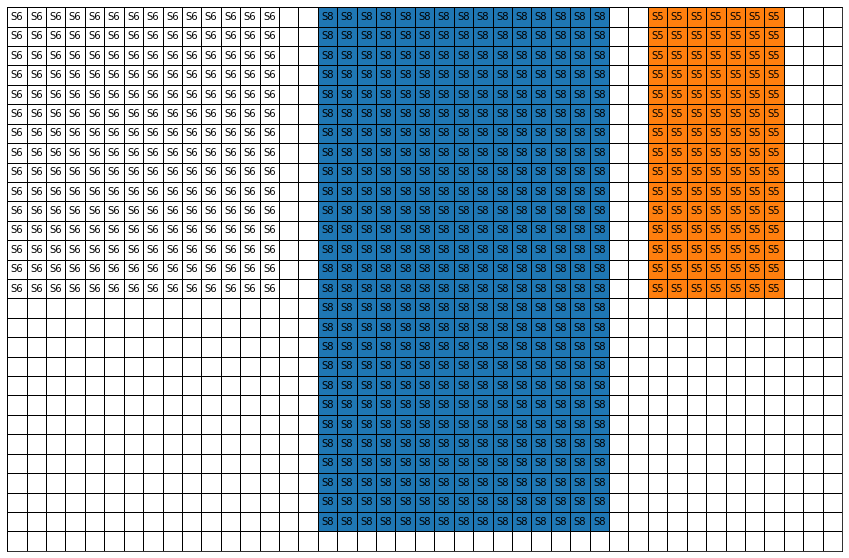

*** 정반명: A, 조회날짜: 2024-01-02 00:00:00


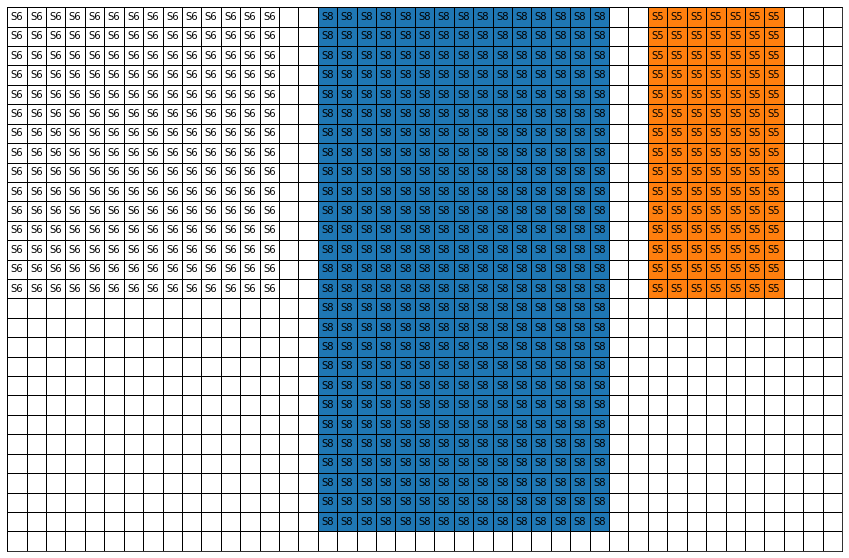

*** 정반명: A, 조회날짜: 2024-01-03 00:00:00


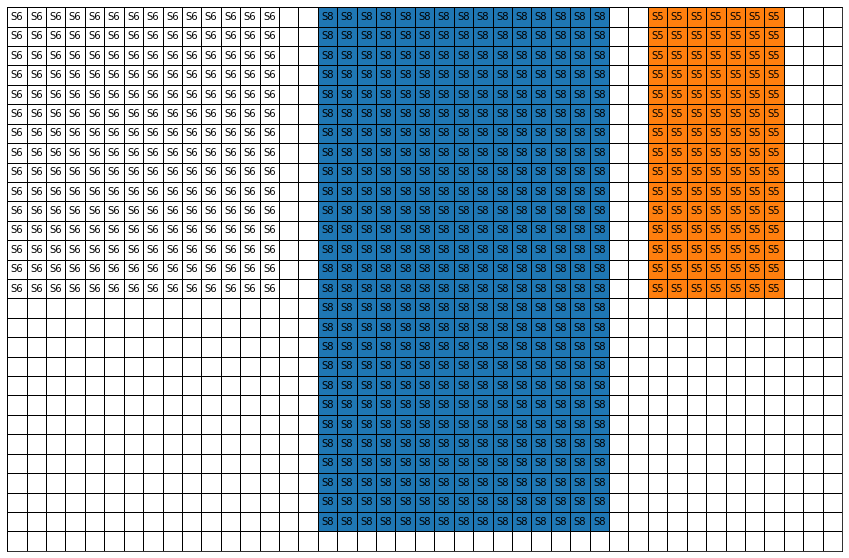

*** 정반명: A, 조회날짜: 2024-01-04 00:00:00


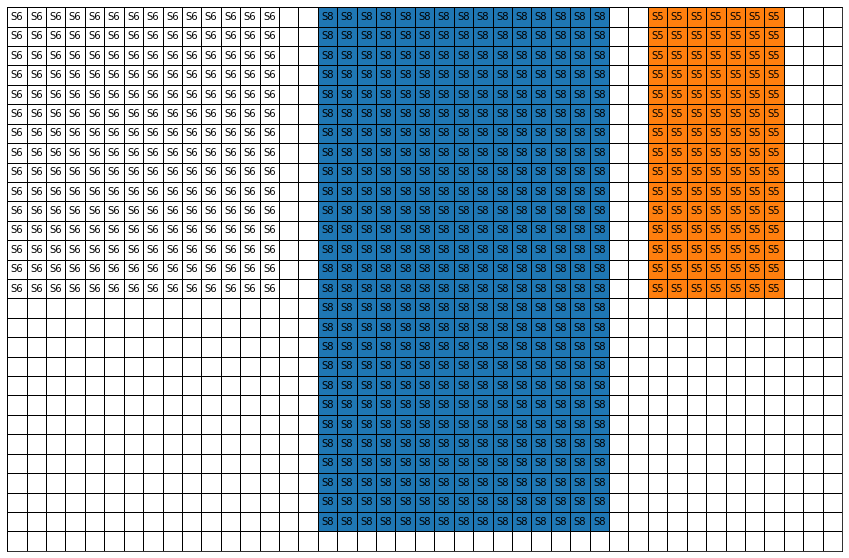

*** 정반명: A, 조회날짜: 2024-01-05 00:00:00


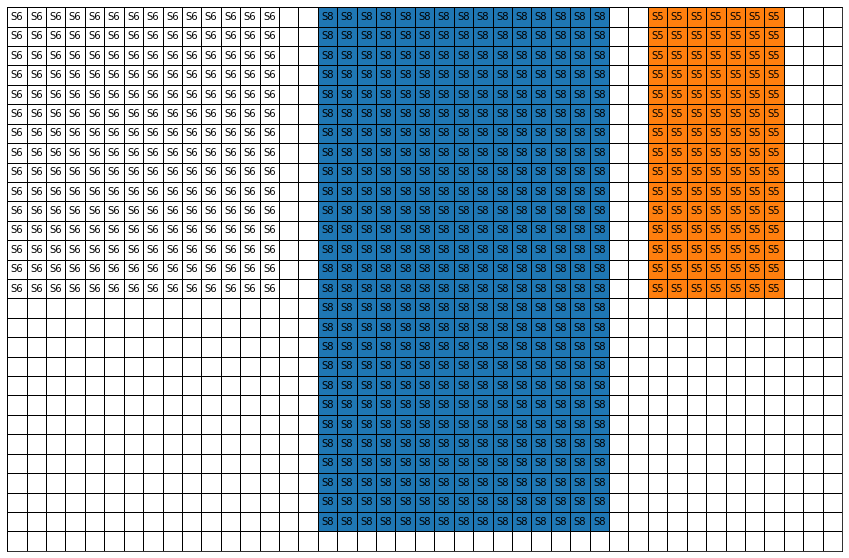

*** 정반명: A, 조회날짜: 2024-01-06 00:00:00


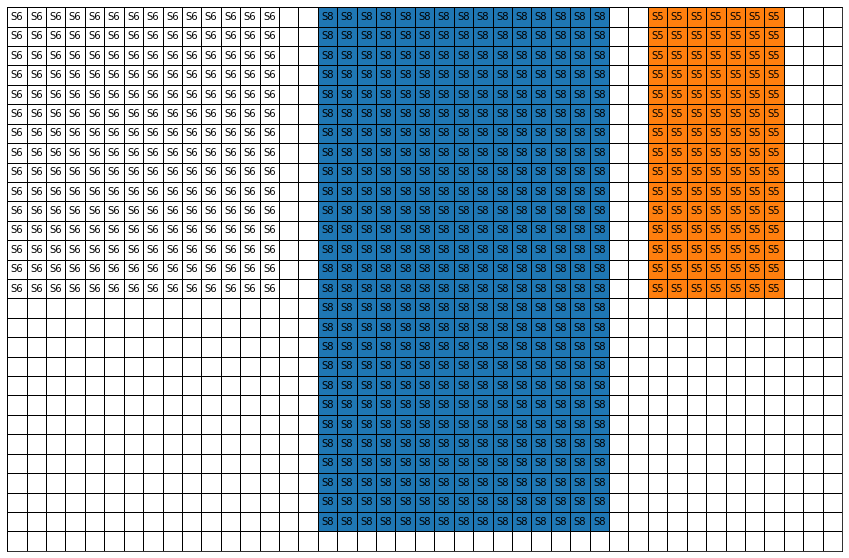

*** 정반명: A, 조회날짜: 2024-01-07 00:00:00


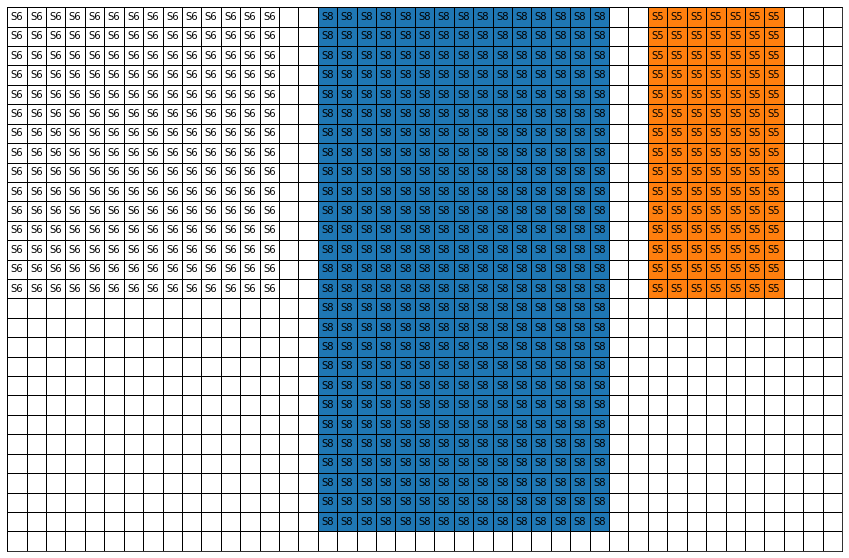

*** 정반명: A, 조회날짜: 2024-01-08 00:00:00


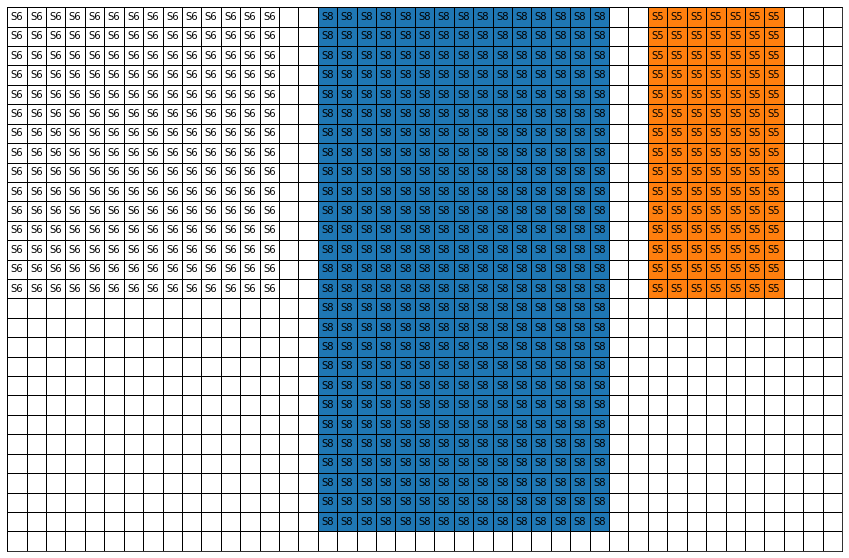

*** 정반명: A, 조회날짜: 2024-01-09 00:00:00


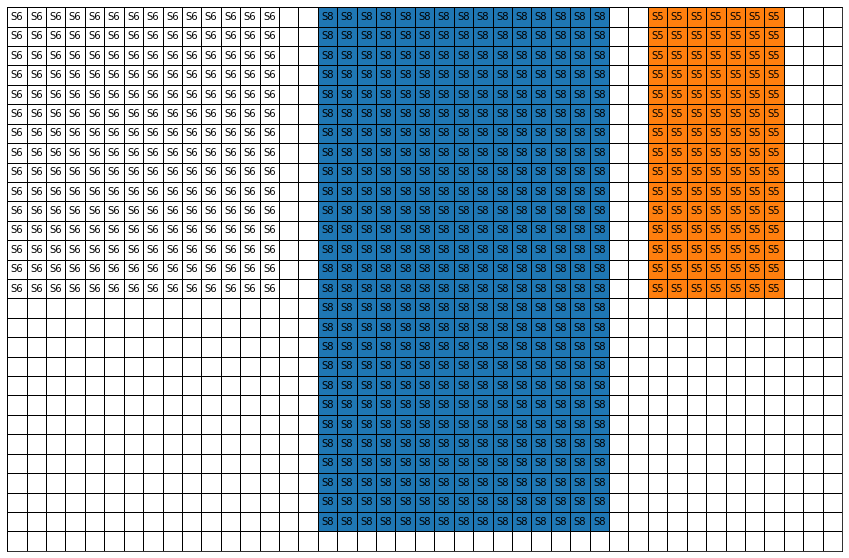

*** 정반명: A, 조회날짜: 2024-01-10 00:00:00


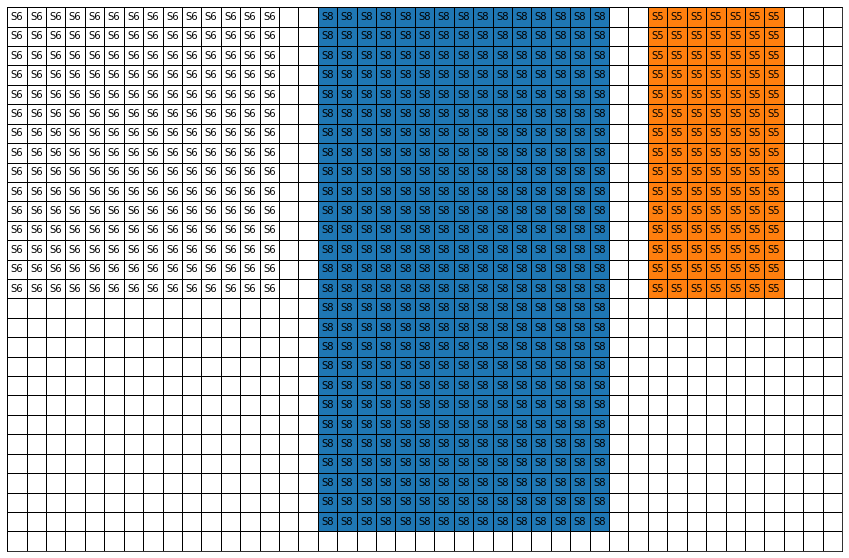

*** 정반명: A, 조회날짜: 2024-01-11 00:00:00


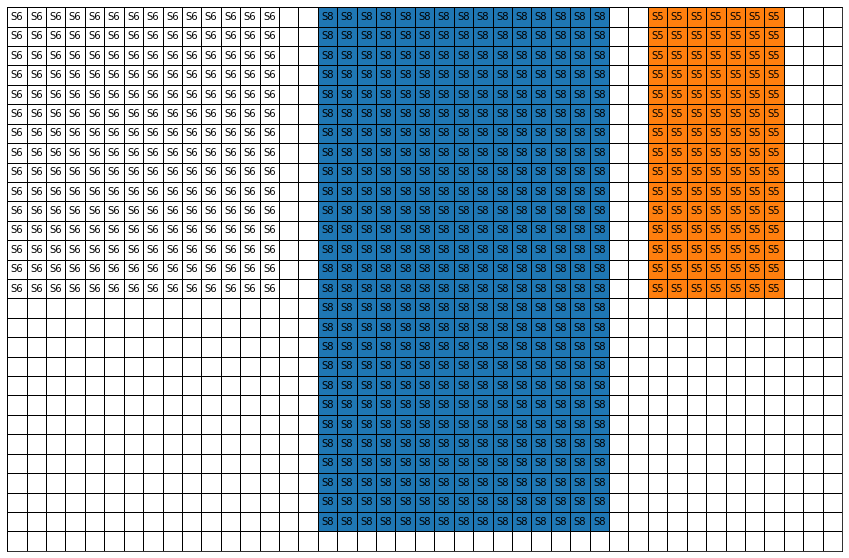

*** 정반명: A, 조회날짜: 2024-01-12 00:00:00


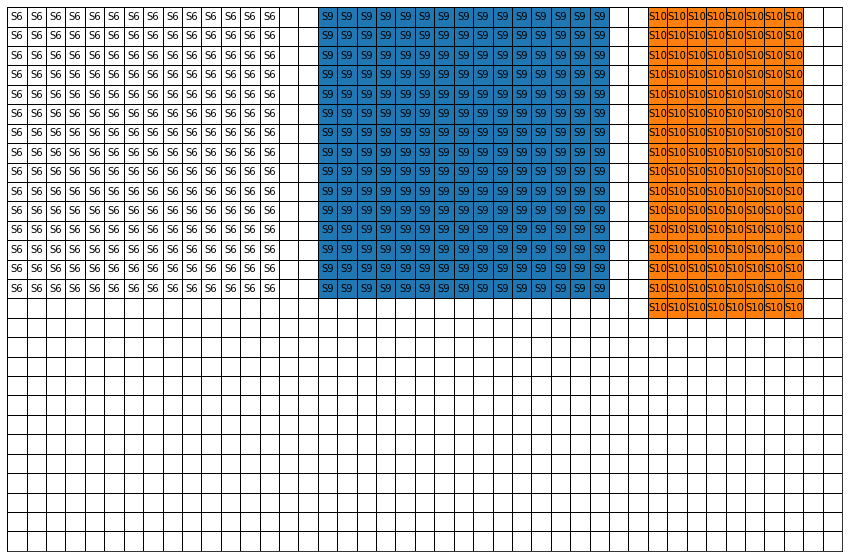

*** 정반명: A, 조회날짜: 2024-01-13 00:00:00


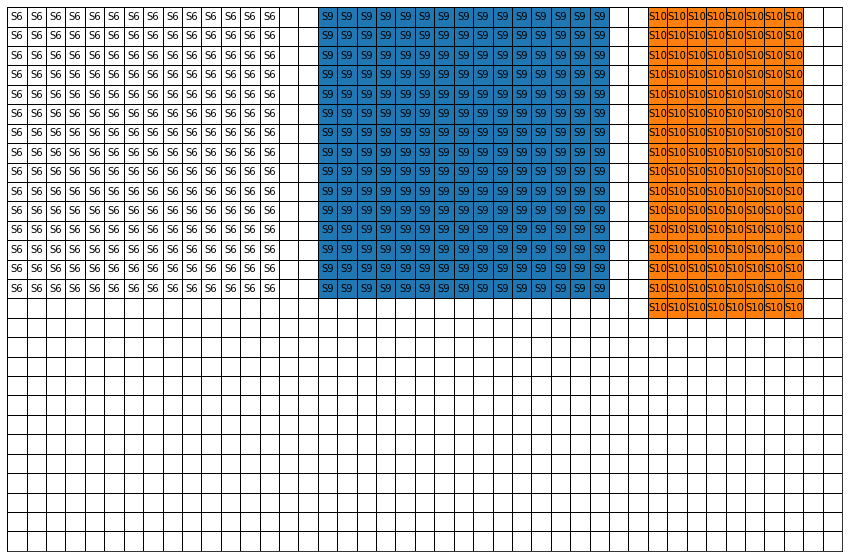

*** 정반명: A, 조회날짜: 2024-01-14 00:00:00


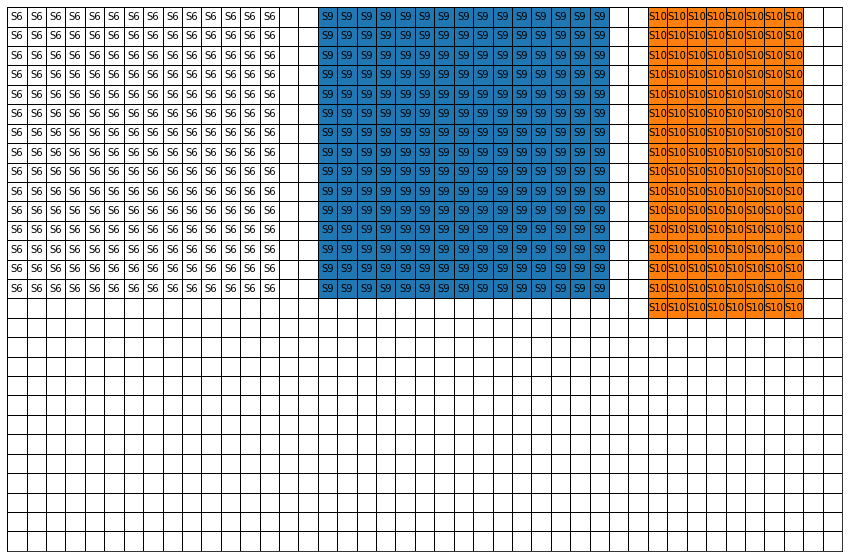

*** 정반명: A, 조회날짜: 2024-01-15 00:00:00


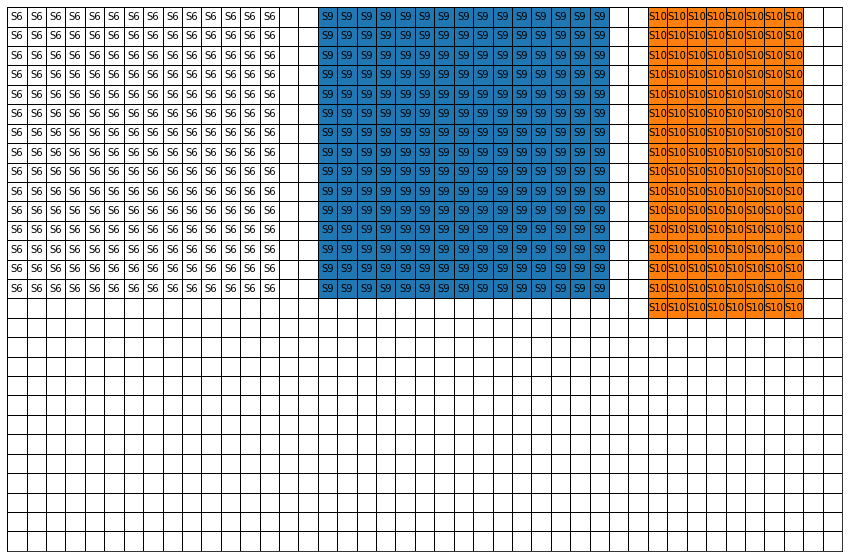

end of iteration


In [161]:
조회날짜리스트 = 면적달력.index[:15]
정반리스트 = 면적달력.columns.tolist()
조회날짜_iter = iter(조회날짜리스트)
정반리스트_iter = iter(정반리스트)

try:
    while True:
        조회날짜 = next(조회날짜_iter)
        for 정반명 in 면적달력.columns:
            print(f"*** 정반명: {정반명}, 조회날짜: {조회날짜}")
            정반배치레이아웃(정반명, 정반데이터, 조회날짜, 블록명달력, 사이즈달력)     
except StopIteration:
    print("end of iteration")

# 가중치 변경 시뮬레이션 (GridSearchCV 방식)

In [ ]:
data_num = "111"

블록원데이터 = pd.read_excel(f"./data/data{data_num}.xlsx", sheet_name="블록데이터")
블록원데이터 = 블록원데이터.iloc[4:,:]

정반원데이터 = pd.read_excel(f"./data/data{data_num}.xlsx", sheet_name="정반데이터")

블록데이터 = 블록데이터전처리(블록원데이터)
정반데이터 = 정반데이터전처리(정반원데이터)
블록데이터.shape, 정반데이터.shape

## Block Weight 후보들
공기가중치들 = [0.9, 0.5, 0.1]
크기가중치들 = [0.1, 0.5, 0.9]
착수일가중치 = 3

배치결과모음 = []

for 공기가중치, 크기가중치 in tqdm(zip(공기가중치들, 크기가중치들)):
    블록데이터 = 블록데이터전처리(블록원데이터)    
    면적달력 = create_면적달력(2024, 1, 2024, 3, 정반데이터)
    블록명달력 = create_블록명달력(2024, 1, 2024, 3, 정반데이터)
    사이즈달력 = create_사이즈달력(2024, 1, 2024, 3, 정반데이터)
    
    생산계획결과 = 생산계획수립(블록데이터, 정반데이터, 면적달력, 블록명달력, 사이즈달력)
    
    결론_블록리스트 = 생산계획결과[0]
    결론_정반리스트 = 생산계획결과[1]
    결론_착수일자 = 생산계획결과[2]
    결론_상태정보 = 생산계획결과[3]
    면적달력 = 생산계획결과[4]
    블록명달력 = 생산계획결과[5]
    사이즈달력 = 생산계획결과[6]

    print(f">>>>>>>> 총 블록 대수: {len(결론_상태정보)}")
    print(f">>>>>>>> 정상배치 블록 대수: {결론_상태정보.count('정상배치완료')}")
    print(f">>>>>>>> 배치못한 블록 대수: {len(결론_상태정보) - 결론_상태정보.count('정상배치완료')}")
    print("-"*70)
    
    fin_df = pd.DataFrame({
    "블록명":결론_블록리스트,
    "정반명":결론_정반리스트,
    "착수일자":결론_착수일자,
    })
    merged_df = pd.merge(블록데이터, fin_df, on="블록명", how="left")
    print(f"결론_상태정보: {결론_상태정보}")
    merged_df["상태정보"] = 결론_상태정보
    
    merged_df["종료일자"] = merged_df[["착수일자", "표준공기"]].apply(종료일구하기, axis=1)
    merged_df["차트텍스트"] = merged_df[["블록명", "표준공기", "사이즈"]].apply(create_text, axis=1)
    
    배치결과모음.append(merged_df)

((14, 14), (1, 8))

0it [00:00, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

*** 검토대상블록: S6, 사이즈: (15, 14), 납기: 2024-01-19T00:00:00.000000000, 표준공기: 18, 최소착수요구일:2024-01-01
*** 중량조건적합정반들: ['A']
*** 최장길이조건적합정반들: ['A']

>>> 제1차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 0, 한계시점인덱스: 0
*** 최선조기착수일후보: {'A': Timestamp('2024-01-01 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-01 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-01
*** 레이아웃 적합도리스트 체크: 적합
*** 정상배치 완료

*** 검토대상블록: S7, 사이즈: (31, 13), 납기: 2024-01-12T00:00:00.000000000, 표준공기: 10, 최소착수요구일:2024-01-02
*** 중량조건적합정반들: ['A']
*** 최장길이조건적합정반들: ['A']

>>> 제1차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 1, 한계시점인덱스: 0
*** 최선조기착수일후보: {'A': Timestamp('2024-01-01 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-01 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-01
1차검토 - Block S7 of height 31 width 13 could not be placed.
2차검토 - Block S7 of height 13 width 31 could not be placed.
1차검토 - Block S7 of height 31 width 13 could not be placed.
2차검토 - Block S7 of height 13 width 31 could not be placed.
1차검토 - Blo

2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 c

1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제9차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 7, 한계시점인덱스: 0
*** 최선조기착수일후보: {'A': Timestamp('2024-01-08 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-08 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-08
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 

1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제3차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 18, 한계시점인덱스: 11
*** 최선조기착수일후보: {'A': Timestamp('2024-01-13 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-13 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-13
1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제4차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 18, 한계시점인덱스: 11
*** 최선조기착수일후보: {'A': Timestamp('2024-01-13 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-13 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-13
1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 

1차검토 - Block S14 of height 16 width 15 could not be placed.
2차검토 - Block S14 of height 15 width 16 could not be placed.
1차검토 - Block S14 of height 16 width 15 could not be placed.
2차검토 - Block S14 of height 15 width 16 could not be placed.
1차검토 - Block S14 of height 16 width 15 could not be placed.
2차검토 - Block S14 of height 15 width 16 could not be placed.
1차검토 - Block S14 of height 16 width 15 could not be placed.
2차검토 - Block S14 of height 15 width 16 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제2차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 22, 한계시점인덱스: 15
*** 최선조기착수일후보: {'A': Timestamp('2024-01-17 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-17 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-17
1차검토 - Block S14 of height 16 width 15 could not be placed.
2차검토 - Block S14 of height 15 width 16 could not be placed.
1차검토 - Block S14 of height 16 width 15 could not be placed.
2차검토 - Block S14 of height 15 width 16 could not be placed.
1차검토 - Block S14 of height 16 widt

*** 레이아웃 적합도리스트 체크: 부적합

>>> 제8차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 22, 한계시점인덱스: 15
*** 최선조기착수일후보: {'A': Timestamp('2024-01-22 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-22 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-22
1차검토 - Block S14 of height 16 width 15 could not be placed.
2차검토 - Block S14 of height 15 width 16 could not be placed.
1차검토 - Block S14 of height 16 width 15 could not be placed.
2차검토 - Block S14 of height 15 width 16 could not be placed.
1차검토 - Block S14 of height 16 width 15 could not be placed.
2차검토 - Block S14 of height 15 width 16 could not be placed.
1차검토 - Block S14 of height 16 width 15 could not be placed.
2차검토 - Block S14 of height 15 width 16 could not be placed.
1차검토 - Block S14 of height 16 width 15 could not be placed.
2차검토 - Block S14 of height 15 width 16 could not be placed.
1차검토 - Block S14 of height 16 width 15 could not be placed.
2차검토 - Block S14 of height 15 width 16 could not be placed.
1차검토 - Block S14 of height 16 widt

1차검토 - Block S18 of height 16 width 13 could not be placed.
2차검토 - Block S18 of height 13 width 16 could not be placed.
1차검토 - Block S18 of height 16 width 13 could not be placed.
2차검토 - Block S18 of height 13 width 16 could not be placed.
1차검토 - Block S18 of height 16 width 13 could not be placed.
2차검토 - Block S18 of height 13 width 16 could not be placed.
1차검토 - Block S18 of height 16 width 13 could not be placed.
2차검토 - Block S18 of height 13 width 16 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제12차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 27, 한계시점인덱스: 20
*** 최선조기착수일후보: {'A': Timestamp('2024-01-25 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-25 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-25
1차검토 - Block S18 of height 16 width 13 could not be placed.
2차검토 - Block S18 of height 13 width 16 could not be placed.
1차검토 - Block S18 of height 16 width 13 could not be placed.
2차검토 - Block S18 of height 13 width 16 could not be placed.
1차검토 - Block S18 of height 16 wid

*** 레이아웃 적합도리스트 체크: 부적합

>>> 제8차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 31, 한계시점인덱스: 24
*** 최선조기착수일후보: {'A': Timestamp('2024-01-28 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-28 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-28
1차검토 - Block S15 of height 14 width 13 could not be placed.
2차검토 - Block S15 of height 13 width 14 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제9차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 31, 한계시점인덱스: 24
*** 최선조기착수일후보: {'A': Timestamp('2024-01-28 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-28 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-28
1차검토 - Block S15 of height 14 width 13 could not be placed.
2차검토 - Block S15 of height 13 width 14 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제10차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 31, 한계시점인덱스: 24
*** 최선조기착수일후보: {'A': Timestamp('2024-01-29 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-29 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-29
*** 레이아웃 적합도리스트 체크: 적

  0%|          | 0/14 [00:00<?, ?it/s]

*** 검토대상블록: S6, 사이즈: (15, 14), 납기: 2024-01-19T00:00:00.000000000, 표준공기: 18, 최소착수요구일:2024-01-01
*** 중량조건적합정반들: ['A']
*** 최장길이조건적합정반들: ['A']

>>> 제1차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 0, 한계시점인덱스: 0
*** 최선조기착수일후보: {'A': Timestamp('2024-01-01 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-01 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-01
*** 레이아웃 적합도리스트 체크: 적합
*** 정상배치 완료

*** 검토대상블록: S7, 사이즈: (31, 13), 납기: 2024-01-12T00:00:00.000000000, 표준공기: 10, 최소착수요구일:2024-01-02
*** 중량조건적합정반들: ['A']
*** 최장길이조건적합정반들: ['A']

>>> 제1차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 1, 한계시점인덱스: 0
*** 최선조기착수일후보: {'A': Timestamp('2024-01-01 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-01 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-01
1차검토 - Block S7 of height 31 width 13 could not be placed.
2차검토 - Block S7 of height 13 width 31 could not be placed.
1차검토 - Block S7 of height 31 width 13 could not be placed.
2차검토 - Block S7 of height 13 width 31 could not be placed.
1차검토 - Blo

1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 c

1차검토 - Block S11 of height 14 width 14 could not be placed.
1차검토 - Block S11 of height 14 width 14 could not be placed.
1차검토 - Block S11 of height 14 width 14 could not be placed.
1차검토 - Block S11 of height 14 width 14 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제2차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 17, 한계시점인덱스: 10
*** 최선조기착수일후보: {'A': Timestamp('2024-01-12 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-12 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-12
1차검토 - Block S11 of height 14 width 14 could not be placed.
1차검토 - Block S11 of height 14 width 14 could not be placed.
1차검토 - Block S11 of height 14 width 14 could not be placed.
1차검토 - Block S11 of height 14 width 14 could not be placed.
1차검토 - Block S11 of height 14 width 14 could not be placed.
1차검토 - Block S11 of height 14 width 14 could not be placed.
1차검토 - Block S11 of height 14 width 14 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제3차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 17, 한계시점인덱스: 10
*** 최선조기착수일후보: {'A'

1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제8차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 18, 한계시점인덱스: 11
*** 최선조기착수일후보: {'A': Timestamp('2024-01-15 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-15 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-15
1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제9차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 18, 한계시점인덱스: 11
*** 최선조기착수일후보: {'A': Timestamp('2024-01-15 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-15 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-15
1차검토 - Block S12 of height 15 width 

2차검토 - Block S16 of height 12 width 14 could not be placed.
1차검토 - Block S16 of height 14 width 12 could not be placed.
2차검토 - Block S16 of height 12 width 14 could not be placed.
1차검토 - Block S16 of height 14 width 12 could not be placed.
2차검토 - Block S16 of height 12 width 14 could not be placed.
1차검토 - Block S16 of height 14 width 12 could not be placed.
2차검토 - Block S16 of height 12 width 14 could not be placed.
1차검토 - Block S16 of height 14 width 12 could not be placed.
2차검토 - Block S16 of height 12 width 14 could not be placed.
1차검토 - Block S16 of height 14 width 12 could not be placed.
2차검토 - Block S16 of height 12 width 14 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제3차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 23, 한계시점인덱스: 16
*** 최선조기착수일후보: {'A': Timestamp('2024-01-20 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-20 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-20
1차검토 - Block S16 of height 14 width 12 could not be placed.
2차검토 - Block S16 of height 12 widt

1차검토 - Block S18 of height 16 width 13 could not be placed.
2차검토 - Block S18 of height 13 width 16 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제8차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 27, 한계시점인덱스: 20
*** 최선조기착수일후보: {'A': Timestamp('2024-01-24 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-24 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-24
1차검토 - Block S18 of height 16 width 13 could not be placed.
2차검토 - Block S18 of height 13 width 16 could not be placed.
1차검토 - Block S18 of height 16 width 13 could not be placed.
2차검토 - Block S18 of height 13 width 16 could not be placed.
1차검토 - Block S18 of height 16 width 13 could not be placed.
2차검토 - Block S18 of height 13 width 16 could not be placed.
1차검토 - Block S18 of height 16 width 13 could not be placed.
2차검토 - Block S18 of height 13 width 16 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제9차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 27, 한계시점인덱스: 20
*** 최선조기착수일후보: {'A': Timestamp('2024-01-24 00:00:00', freq='D')}
>>> 최소요구납기충족리스

*** 레이아웃 적합도리스트 체크: 부적합

>>> 제5차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 31, 한계시점인덱스: 24
*** 최선조기착수일후보: {'A': Timestamp('2024-01-27 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-27 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-27
1차검토 - Block S15 of height 14 width 13 could not be placed.
2차검토 - Block S15 of height 13 width 14 could not be placed.
1차검토 - Block S15 of height 14 width 13 could not be placed.
2차검토 - Block S15 of height 13 width 14 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제6차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 31, 한계시점인덱스: 24
*** 최선조기착수일후보: {'A': Timestamp('2024-01-27 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-27 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-27
1차검토 - Block S15 of height 14 width 13 could not be placed.
2차검토 - Block S15 of height 13 width 14 could not be placed.
1차검토 - Block S15 of height 14 width 13 could not be placed.
2차검토 - Block S15 of height 13 width 14 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>>

  0%|          | 0/14 [00:00<?, ?it/s]

*** 검토대상블록: S6, 사이즈: (15, 14), 납기: 2024-01-19T00:00:00.000000000, 표준공기: 18, 최소착수요구일:2024-01-01
*** 중량조건적합정반들: ['A']
*** 최장길이조건적합정반들: ['A']

>>> 제1차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 0, 한계시점인덱스: 0
*** 최선조기착수일후보: {'A': Timestamp('2024-01-01 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-01 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-01
*** 레이아웃 적합도리스트 체크: 적합
*** 정상배치 완료

*** 검토대상블록: S7, 사이즈: (31, 13), 납기: 2024-01-12T00:00:00.000000000, 표준공기: 10, 최소착수요구일:2024-01-02
*** 중량조건적합정반들: ['A']
*** 최장길이조건적합정반들: ['A']

>>> 제1차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 1, 한계시점인덱스: 0
*** 최선조기착수일후보: {'A': Timestamp('2024-01-01 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-01 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-01
1차검토 - Block S7 of height 31 width 13 could not be placed.
2차검토 - Block S7 of height 13 width 31 could not be placed.
1차검토 - Block S7 of height 31 width 13 could not be placed.
2차검토 - Block S7 of height 13 width 31 could not be placed.
1차검토 - Blo

2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 26 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제5차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 7, 한계시점인덱스: 0
*** 최선조기착수일후보: {'A': Timestamp('2024-01-05 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-05 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-05
1차검토 - Block S13 of height 26 width 14 could not be placed.
2차검토 - Block S13 of height 14 width 

1차검토 - Block S11 of height 14 width 14 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제2차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 17, 한계시점인덱스: 10
*** 최선조기착수일후보: {'A': Timestamp('2024-01-12 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-12 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-12
1차검토 - Block S11 of height 14 width 14 could not be placed.
1차검토 - Block S11 of height 14 width 14 could not be placed.
1차검토 - Block S11 of height 14 width 14 could not be placed.
1차검토 - Block S11 of height 14 width 14 could not be placed.
1차검토 - Block S11 of height 14 width 14 could not be placed.
1차검토 - Block S11 of height 14 width 14 could not be placed.
1차검토 - Block S11 of height 14 width 14 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제3차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 17, 한계시점인덱스: 10
*** 최선조기착수일후보: {'A': Timestamp('2024-01-14 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-14 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-14
1차검토 - Block S11 of height 1

*** 레이아웃 적합도리스트 체크: 부적합

>>> 제8차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 18, 한계시점인덱스: 11
*** 최선조기착수일후보: {'A': Timestamp('2024-01-15 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-15 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-15
1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제9차 레이아웃 적합도 검토
최소착수요구일달력인덱스: 18, 한계시점인덱스: 11
*** 최선조기착수일후보: {'A': Timestamp('2024-01-15 00:00:00', freq='D')}
>>> 최소요구납기충족리스트: [('A', Timestamp('2024-01-15 00:00:00', freq='D'))]
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-01-15
1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
1차검토 - Block S12 of height 15 width 8 could not be placed.
*** 레이아웃 적합도리스트 체크: 부적합

>>> 제10차 레이

1차검토 - Block S16 of height 14 width 12 could not be placed.
2차검토 - Block S16 of height 12 width 14 could not be placed.
1차검토 - Block S16 of height 14 width 12 could not be placed.
2차검토 - Block S16 of height 12 width 14 could not be placed.
1차검토 - Block S16 of height 14 width 12 could not be placed.
2차검토 - Block S16 of height 12 width 14 could not be placed.
1차검토 - Block S16 of height 14 width 12 could not be placed.
2차검토 - Block S16 of height 12 width 14 could not be placed.
1차검토 - Block S16 of height 14 width 12 could not be placed.
2차검토 - Block S16 of height 12 width 14 could not be placed.
1차검토 - Block S16 of height 14 width 12 could not be placed.
2차검토 - Block S16 of height 12 width 14 could not be placed.
1차검토 - Block S16 of height 14 width 12 could not be placed.
2차검토 - Block S16 of height 12 width 14 could not be placed.


In [ ]:
for i in range(len(공기가중치들)):
    draw_gant(배치결과모음[i])